In [16]:
# Imports
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
import matplotlib as mpl
import torch.nn.functional as F

In [17]:
def Gabor_filters(out_channels=6, K=7, dfrom =0, dto=180, annotation=False):
  """ Create gabors filters
  out_channels = the number of convolutional filter channel; the number of filters
  K = Filter axis size, the whole size is K x K matrix
  (dfrom to dto): Range of anlge of Selective Orientation 
  Returns:
      filters: out_channels x K x K
  """
  grid = np.linspace(-K/2, K/2, K).astype(np.float32)
  xx,yy = np.meshgrid(grid, grid, indexing='ij')

  sigma = 1.1
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
  wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
    
      
  # create gabor filters
  thetas = np.linspace(dfrom, dto, out_channels+1)[:-1] * np.pi/180
  gabors = np.zeros((len(thetas), K, K), np.float32)
  lam = 10
  phi = np.pi/2
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
  for i,theta in enumerate(thetas):
    x = xx*np.cos(theta) + yy*np.sin(theta)
    gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

  filters = gabors
  filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
  filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
  if annotation: 
      print('shape 1st gabor', gabors[1].shape)
      print('shape total gabors',gabors.shape)

  # convert to torch
  filters = torch.from_numpy(filters)
  # add channel axis
  filters = filters.unsqueeze(1)
  
  if annotation: print('total filters with one more channel axis', filters.shape)
  return filters
example_filters = Gabor_filters(out_channels=100, K=7, annotation=True)

shape 1st gabor (7, 7)
shape total gabors (100, 7, 7)
total filters with one more channel axis torch.Size([100, 1, 7, 7])


In [18]:
def grating(angle, wpix=640, hpix=480, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    wpix, hpix : # width and height of image in pixels for res=1.0
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """
  angle = np.deg2rad(angle)  # transform to radians

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  gratings -= 0.5

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)

In [22]:
def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img+0.5, cmap=mpl.cm.binary)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

In [19]:
# Stimulus parameters
in_channels = 1 # how many input channels in our images
h = 32 # height of images
w = 32 # width of images

# Range of Orientation Grating Angle Degree
Degree_from=0
Degree_to=180

In [20]:
# Convolutional filter parameters
K = 7 # filter size
out_channels = 100 # how many convolutional channels to have in our layer
example_filters = Gabor_filters(out_channels, K, Degree_from, Degree_to) # create filters to use

In [29]:
# Create stimuli (H_in, W_in)
orientations=np.linspace(Degree_from, Degree_to, out_channels*2)
stimuli = torch.zeros((len(orientations), in_channels, h, w), dtype=torch.float32)

for i,ori in enumerate(orientations):
  stimulus = grating(ori, wpix=w*10, hpix=h*10)
  stimuli[i,0] = stimulus

img shape: torch.Size([32, 32]) torch.Size([200, 1, 32, 32])
orientation: 0.0 radian: 0.0


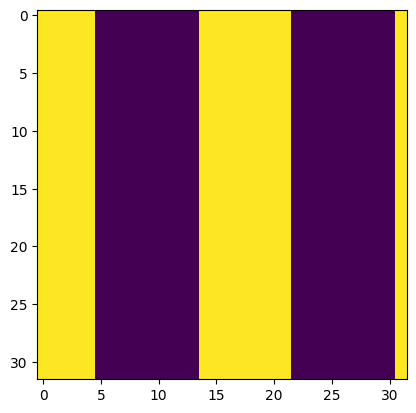

In [34]:
# Plot a sample grating input
print('img shape:', np.shape(stimuli[0,0] ), np.shape(stimuli ))
print('orientation:', orientations[0], 'radian:',  np.deg2rad(orientations[0]))
plt.imshow(stimulus)

5 40


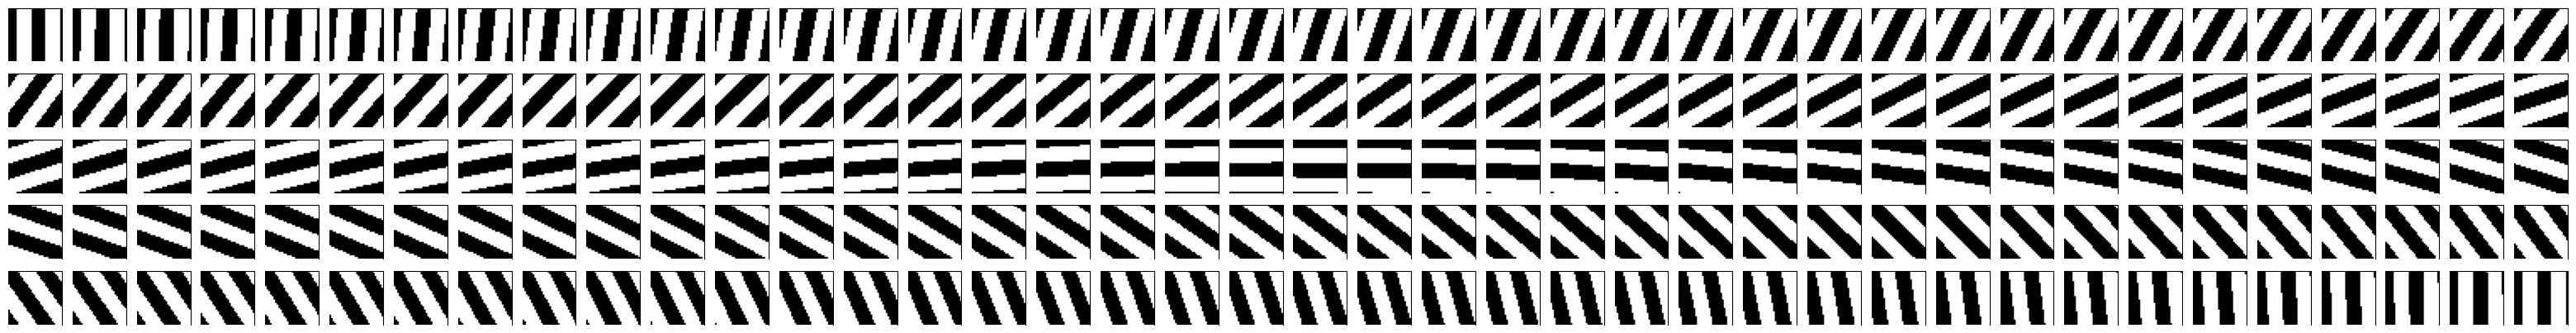

In [25]:
# Plot created grating images
fig_size=1
num_row=5
n_col = int(len(stimuli)/num_row)

fig, axs = plt.subplots(num_row, n_col, figsize=(fig_size* n_col, fig_size*num_row))
print(num_row, n_col)

ind_row=0
for r in range(num_row):
  for c in range(n_col):
    ind=c + r*n_col
    ori = stimuli[ind]
    img_stim = torch.squeeze(ori)
    show_stimulus(img_stim, axs[r, c])


5 20


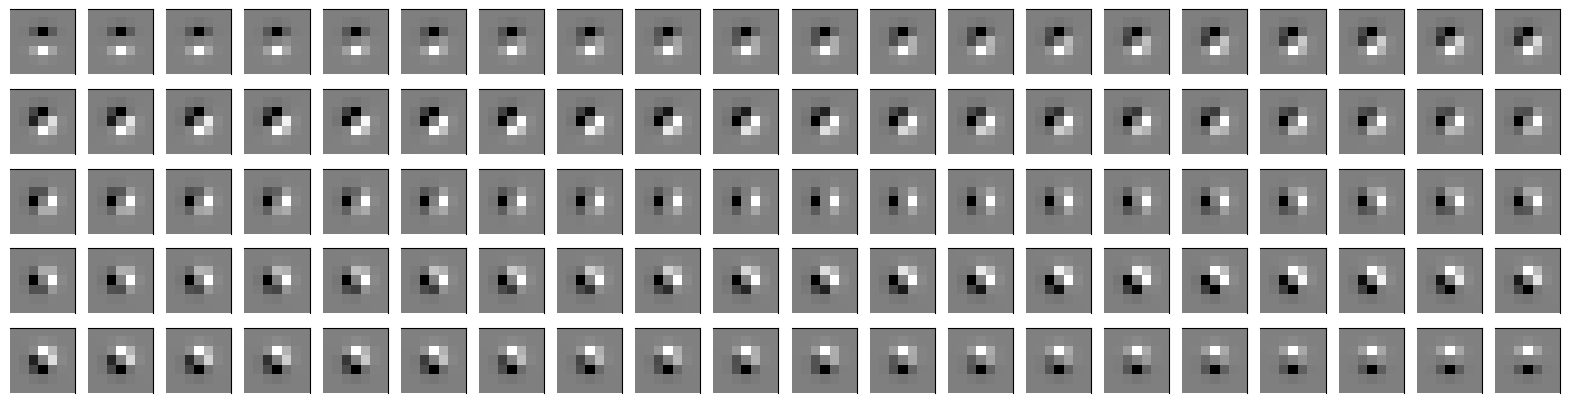

In [35]:
# Plot Created Filters
fig_size=1
num_row=5
n_col = int(len(example_filters)/5)
fig, axs = plt.subplots(num_row, n_col, figsize=(fig_size* n_col, fig_size*num_row))
print(num_row, n_col)

ind_row=0
for r in range(num_row):
  for c in range(n_col):
    ind=c + r*n_col
    ori = example_filters[ind]
    img_filter = torch.squeeze(ori)
    #axs[i].set_title(f'{ori: .0f}$^o$')
    show_stimulus(img_filter, axs[r, c])


In [36]:
class ConvolutionalLayer(nn.Module): # Define Torch Conv layers
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv2d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=6, K=7, filters=None):
    """Initialize layer

    Args:
        c_in: number of input stimulus channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter
        filters: (optional) initialize the convolutional weights

    """
    super().__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    if filters is not None:
      self.conv.weight = nn.Parameter(filters)
      self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

  def forward(self, s):
    """Run stimulus through convolutional layer

    Args:
        s (torch.Tensor): n_stimuli x c_in x h x w tensor with stimuli

    Returns:
        (torch.Tensor): n_stimuli x c_out x h x w tensor with convolutional layer unit activations.

    """
    a = self.conv(s)  # output of convolutional layer
    a = F.relu(a)

    return a

In [37]:
# Initialize conv layer and add weights from function filters
# you need to specify :
# * the number of input channels c_in
# * the number of output channels c_out
# * the filter size K
convLayer = ConvolutionalLayer(c_in=in_channels, c_out=out_channels, K=K, filters=example_filters)
convout = convLayer(stimuli)
convout = convout.detach() # detach gradients

In [90]:
print('Stimulus input:', np.shape(stimuli), type(stimuli))
print('Conv output:', convout.shape) # Output shape: [# of input, # of filters, input width, input height ]

Stimulus input: torch.Size([200, 1, 32, 32]) <class 'torch.Tensor'>
Conv output: torch.Size([200, 100, 32, 32])


In [49]:
sresp=[] #Integrated Stimuli responses for all cells 
# Output of a cell, conv output map is mixed up as a single value to represent a response strength
for neuron in range(convout.shape[1]):
  neuron_resp=[]
  for trial in range(convout.shape[0]):
    filter_output = convout[trial,neuron,:,:]
    sum_output =torch.sum(filter_output)
    neuron_resp.append(sum_output)
  sresp.append(neuron_resp)

In [57]:
def squeeze_response_maps(original_map, connectivity):
    #Squeeze stimulus-response map by mixing cell outputs according to the connectivity to the subsequent layer
    #If connectivity = 2, two output values of the nearest indices are integrated, and the total size of the map will be reduced to half
    new_map=[]
    for i in range(0, len(original_map), connectivity):
        batch = original_map[i:i+connectivity]
        #print(i,'-th batch:\n', batch)
        sumemd = np.sum(batch, axis=0)
        #print('sumemd:\n', sumemd)
        new_map.append(sumemd)
    return new_map

In [91]:
connectivity=2
summed_sresp = squeeze_response_maps(sresp, connectivity)

shuffled_sresp=np.random.permutation(sresp)
summed_sresp_shuffled = squeeze_response_maps(shuffled_sresp, connectivity)

In [93]:
print('Stimuli response map len:', len(sresp), 'shape:', np.shape(sresp)) # (#filters, # stimuli (neurons))
print('Summed reseponse map len:', len(summed_sresp), 'shape:', np.shape(summed_sresp)) # (# stimuli, #filters (neurons))

Stimuli response map len: 100 shape: (100, 200)
Summed reseponse map len: 50 shape: (50, 200)


In [94]:
def sort_by_k_index(arr, kth, dir='lar', sortby='sum'): # sort array by index of k largest numbers in rows
  arr=np.array(arr)
  order = []
  for row in arr:
    if dir=='lar': ind = np.argpartition(row, -kth)[-kth:] #largest
    else: ind = np.argpartition(row, kth)[:kth] #smallest
    top4 = row[ind]
    
    if sortby=='sum':
      sum = np.sum(ind)
    else: sum = np.average(ind)
    order.append(sum)
    
  if dir=='lar': ind_order = np.argpartition(order, -1)
  else: ind_order = np.argpartition(order, 1)
  return arr[ind_order]

In [97]:
#sorted_shuffled = sort_by_k_index(summed_sresp_shuffled, 20, dir='sm')
sorted_shuffled = sort_by_k_index(summed_sresp_shuffled, 150)

Text(0.5, 25.722222222222214, 'Stimulus Trials')

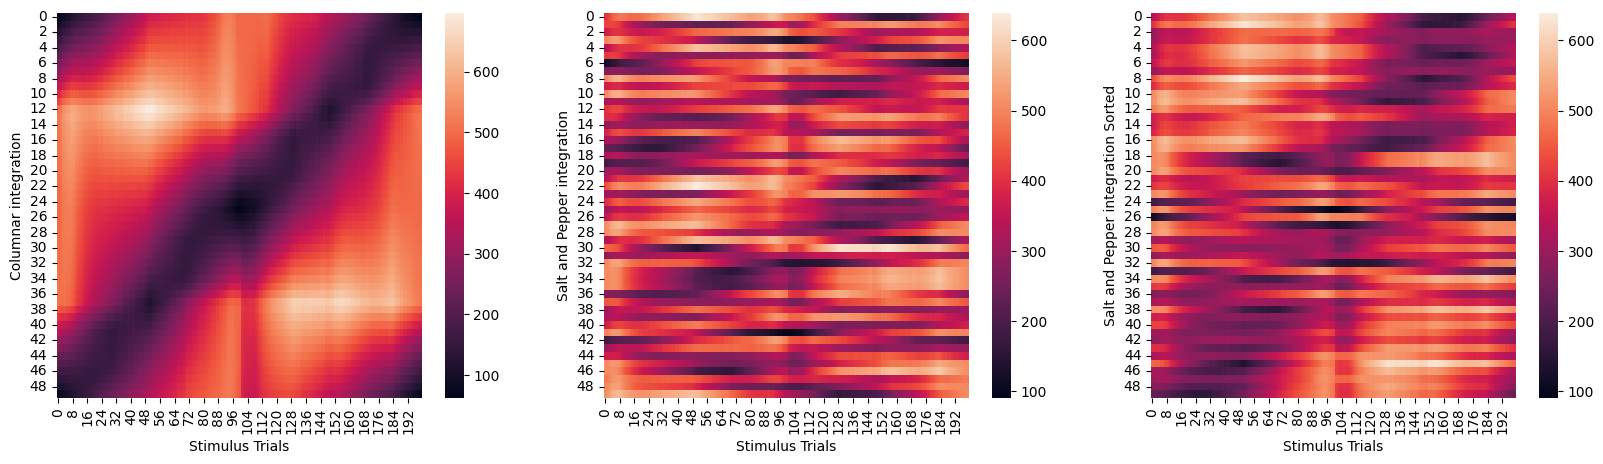

In [100]:
import seaborn as sns

#plt.figure(figsize=(12, 6))

fig, axs = plt.subplots(1,3, figsize=(20,5))
sns.heatmap(summed_sresp, ax=axs[0])
axs[0].set_ylabel('Columnar integration')
axs[0].set_xlabel('Stimulus Trials')

sns.heatmap(summed_sresp_shuffled, ax=axs[1])
axs[1].set_ylabel('Salt and Pepper integration')
axs[1].set_xlabel('Stimulus Trials')

sns.heatmap(sorted_shuffled, ax=axs[2])
axs[2].set_ylabel('Salt and Pepper integration Sorted')
axs[2].set_xlabel('Stimulus Trials')